In [93]:
# inizializziamo la SparkSession e importiamo le librerie
import findspark

location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Houses Price") \
    .getOrCreate()

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
# Carichiamo il data set
trainDF = spark.read.csv('hdfs://localhost:9000/user/vito/input/train.csv', header = 'True', inferSchema='True', nullValue='NA')
testDF = spark.read.csv('hdfs://localhost:9000/user/vito/input/test.csv', header = 'True', inferSchema='True', nullValue='NA')

In [96]:
trainDF.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [97]:
# verifichiamo la presenza di valori nulli
df = trainDF.toPandas()

featuresNull = df.isna().sum().sort_values( ascending=False )
print(featuresNull)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
                 ... 
CentralAir          0
SaleCondition       0
Heating             0
TotalBsmtSF         0
Id                  0
Length: 81, dtype: int64


Text(0.5, 1.0, 'Percentuale di valori mancanti per ogni feature')

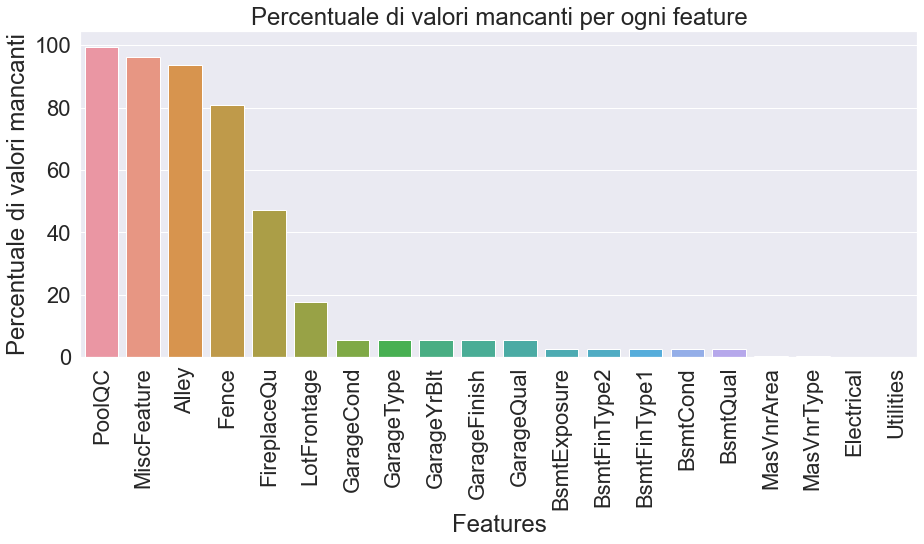

In [98]:
# calcolo la percentuale di dati mancanti per ogni feature

missing_ratio = ( ( df.isna().sum() / len(df)) * 100 ).sort_values(ascending=False)

plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_ratio.index[:20], y=missing_ratio[:20]) #prendo le prime 20 per una migliore visualizzazione
plt.xlabel('Features')
plt.ylabel('Percentuale di valori mancanti')
plt.title('Percentuale di valori mancanti per ogni feature')

In [99]:
# cancelliamo le features che hanno una percentuale di valori nulli sopra 80% (1168)

theshold = 0.8
n_values_not_null = len(df) * (1 - theshold)
df_clean = df.dropna(axis='columns', thresh=n_values_not_null, inplace=False)

Text(0.5, 1.0, 'Percentuale di valori mancanti per ogni feature')

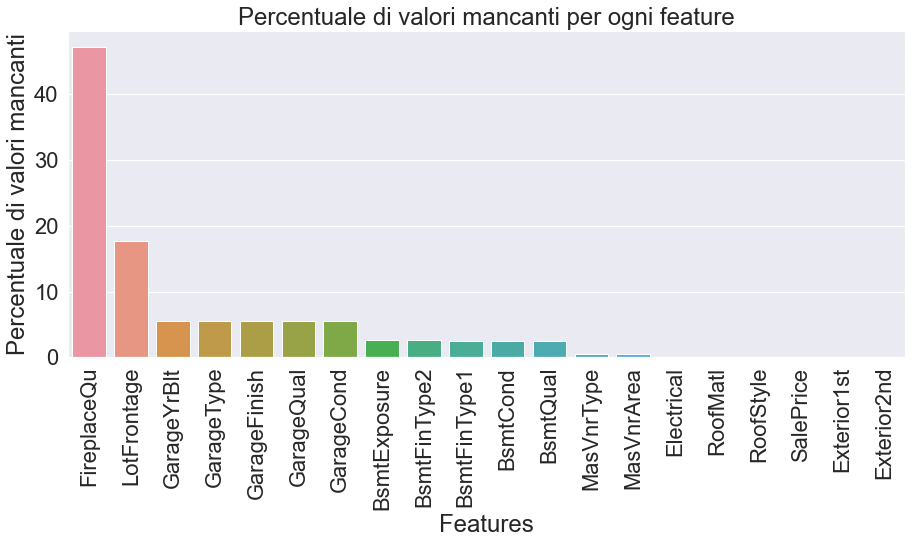

In [100]:
missing_ratio_2 = ( ( df_clean.isna().sum() / len(df_clean)) * 100 ).sort_values(ascending=False)

plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_ratio_2.index[:20], y=missing_ratio_2[:20]) #prendo le prime 20 per visualizzarle meglio
plt.xlabel('Features')
plt.ylabel('Percentuale di valori mancanti')
plt.title('Percentuale di valori mancanti per ogni feature')

In [101]:
missing_data = df_clean.isna().sum()
missing_data = missing_data[ missing_data != 0].sort_values(ascending=False)
print(missing_data)

FireplaceQu     690
LotFrontage     259
GarageCond       81
GarageQual       81
GarageFinish     81
GarageYrBlt      81
GarageType       81
BsmtFinType2     38
BsmtExposure     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrArea        8
MasVnrType        8
Electrical        1
dtype: int64


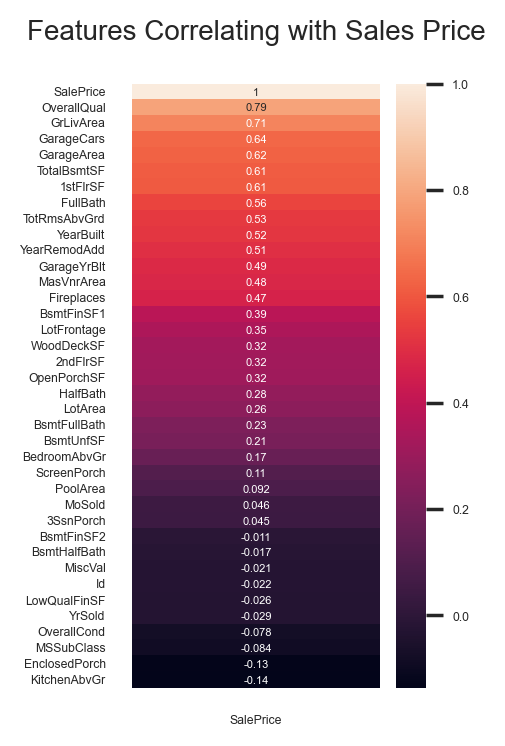

In [102]:
# vediamo la correlazione solo con il prezzo di vendita

corrSP = df.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)

plt.figure(figsize=(2, 4), dpi = 200) 
sns.set(font_scale = 0.4)

sns.heatmap(corrSP, annot=True, annot_kws={"fontsize":4},).set_title('Features Correlating with Sales Price', fontdict={'fontsize':10}, pad=16);

In [103]:
# prendiamo le feature che hanno un valore di correlazione >= 0.5 ed eliminiamo la colonna SalePrice che avrà valore 1 
featuresSelect = corrSP['SalePrice'][ corrSP['SalePrice'] >= 0.5].drop('SalePrice')

print(featuresSelect)

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64


In [104]:
df_clean.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [105]:
print(df_clean['SaleCondition'].unique())

['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']
